# Data preparation

In [32]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

## Treasury bond rates

https://finance.yahoo.com/bonds/

- ^IRX : 13 week Treasury Bill
- ^FVX : Treasury Yield 5 years
- ^TNX : Treasury Yield 10 years
- ^TYX : Treasury Yield 30 years

- Scale : %
- frequency : daily (B)

In [2]:
treasury_bonds = ["^IRX", "^FVX", "^TNX", "^TYX"]

tb = yf.Tickers(treasury_bonds)
df_tb = tb.history(period="max")["Close"]

df_tb.rename(columns={"^IRX":"13W", "^FVX":"5Y", "^TNX":"10Y", "^TYX":"30Y"}, inplace=True)
df_tb.tail()

[*********************100%***********************]  4 of 4 completed


,5Y,13W,10Y,30Y
Date,,,,
2023-08-28,4.412,5.323,4.212,4.291
2023-08-29,4.277,5.320,4.122,4.237
2023-08-30,4.273,5.315,4.118,4.228
2023-08-31,4.244,5.298,4.093,4.204
2023-09-01,4.270,5.275,4.159,4.285


## Tesla stock price

In [3]:
tesla = yf.Ticker("TSLA")
df_tesla = tesla.history(period="max")[["Close"]]
df_tesla.tail()

,Close
Date,
2023-08-25 00:00:00-04:00,238.589996
2023-08-28 00:00:00-04:00,238.820007
2023-08-29 00:00:00-04:00,257.179993
2023-08-30 00:00:00-04:00,256.899994
2023-08-31 00:00:00-04:00,258.079987


## FED Fund rates

- Source : https://fred.stlouisfed.org/series/FEDFUNDS
- frequency : monthly
- path : './datasets/FEDFUNDS.csv'

In [34]:
df_fed = pd.read_csv('./datasets/FEDFUNDS.csv')

# set "DATE" column to index
df_fed.set_index("DATE", inplace=True)
# convert index to datetime index
df_fed.index = pd.to_datetime(df_fed.index, utc=True)

df_fed.head()

,FEDFUNDS
DATE,
1954-07-01 00:00:00+00:00,0.80
1954-08-01 00:00:00+00:00,1.22
1954-09-01 00:00:00+00:00,1.07
1954-10-01 00:00:00+00:00,0.85
1954-11-01 00:00:00+00:00,0.83


## Integrate dataframes

### Daily data

In [10]:
df_tb.index = pd.to_datetime(df_tb.index, utc=True).strftime("%Y-%m-%d")
df_tesla.index = pd.to_datetime(df_tesla.index, utc=True).strftime("%Y-%m-%d")

df_daily = pd.merge(df_tb, df_tesla, how="inner", left_index=True, right_index=True)
df_daily.rename(columns={"Close":"Price"}, inplace=True)
df_daily.index = pd.to_datetime(df_daily.index, utc=True)
df_daily.head()

,5Y,13W,10Y,30Y,Price
Date,,,,,
2010-06-29 00:00:00+00:00,1.786,0.160,2.967,3.946,1.592667
2010-06-30 00:00:00+00:00,1.795,0.170,2.951,3.909,1.588667
2010-07-01 00:00:00+00:00,1.795,0.165,2.927,3.868,1.464000
2010-07-02 00:00:00+00:00,1.812,0.160,2.979,3.941,1.280000
2010-07-06 00:00:00+00:00,1.760,0.160,2.932,3.892,1.074000


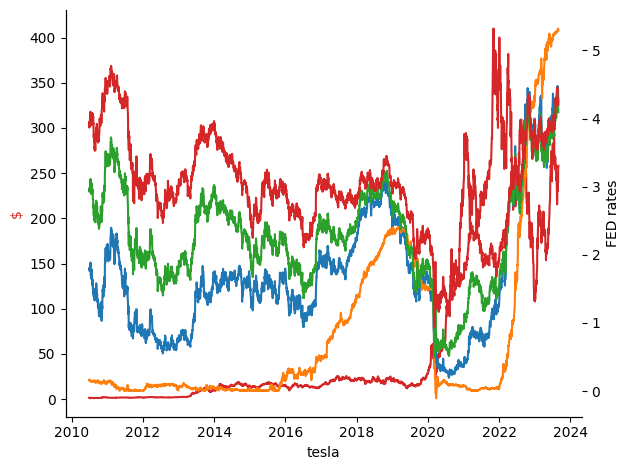

In [40]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('tesla')
ax1.set_ylabel('$', color=color)
ax1.plot(df_daily.index, df_daily["Price"], color=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('FED rates')
ax2.plot(df_daily.index, df_daily[["5Y", "13W", "10Y", "30Y"]])

fig.tight_layout()
sns.despine()

In [27]:
df_monthly = pd.merge(df_fed, df_daily, how="inner", left_index=True, right_index=True)
df_monthly.head()

,FEDFUNDS,5Y,13W,10Y,30Y,Price
2010-07-01 00:00:00+00:00,0.18,1.795,0.165,2.927,3.868,1.464000
2010-09-01 00:00:00+00:00,0.19,1.409,0.130,2.582,3.662,1.363333
2010-10-01 00:00:00+00:00,0.19,1.271,0.150,2.526,3.721,1.373333
2010-11-01 00:00:00+00:00,0.19,1.163,0.105,2.628,4.017,1.427333
2010-12-01 00:00:00+00:00,0.18,1.622,0.155,2.964,4.237,2.290000


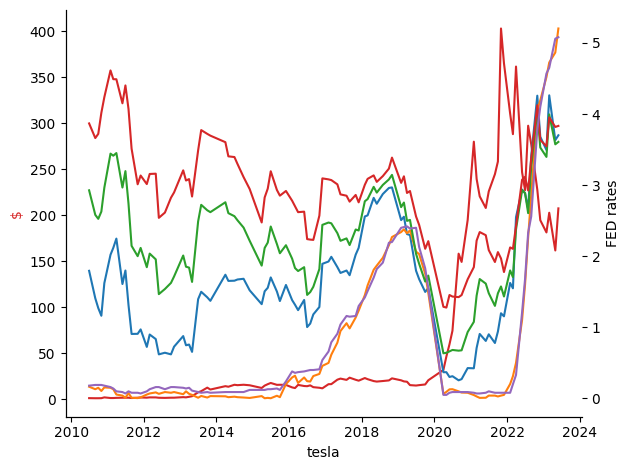

In [41]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('tesla')
ax1.set_ylabel('$', color=color)
ax1.plot(df_monthly.index, df_monthly["Price"], color=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('FED rates')
ax2.plot(df_monthly.index, df_monthly[["5Y", "13W", "10Y", "30Y", "FEDFUNDS"]])

fig.tight_layout()
sns.despine()

# Correlation Analysis

## Correlation with Price

### Daily data

In [28]:
# correlation
df_daily.corr()

,5Y,13W,10Y,30Y,Price
5Y,1.000000,0.845130,0.873304,0.558143,0.252323
13W,0.845130,1.000000,0.601574,0.270127,0.315532
10Y,0.873304,0.601574,1.000000,0.886563,0.006551
30Y,0.558143,0.270127,0.886563,1.000000,-0.246455
Price,0.252323,0.315532,0.006551,-0.246455,1.000000


In [46]:
# pearson correlation
cols = df_daily.columns[df_daily.columns != "Price"]
for col in cols:
    corr = stats.pearsonr(df_daily["Price"], df_daily[col])
    print("-", col, ":", corr)
    print("")
    

- 5Y : PearsonRResult(statistic=0.252322738331312, pvalue=2.6718167380083755e-49)

- 13W : PearsonRResult(statistic=0.3155320545252404, pvalue=1.6533872189434185e-77)

- 10Y : PearsonRResult(statistic=0.006551019347972065, pvalue=0.7061835563778683)

- 30Y : PearsonRResult(statistic=-0.24645464941164713, pvalue=4.803227296265723e-47)



### Monthly data

In [47]:
df_monthly.corr()

,FEDFUNDS,5Y,13W,10Y,30Y,Price
FEDFUNDS,1.000000,0.828300,0.997624,0.579947,0.253015,0.216192
5Y,0.828300,1.000000,0.836364,0.865706,0.543306,0.180876
13W,0.997624,0.836364,1.000000,0.583874,0.250560,0.241281
10Y,0.579947,0.865706,0.583874,1.000000,0.885427,-0.083016
30Y,0.253015,0.543306,0.250560,0.885427,1.000000,-0.337444
Price,0.216192,0.180876,0.241281,-0.083016,-0.337444,1.000000


In [48]:
# Pearson correlation
cols = df_daily.columns[df_daily.columns != "Price"]

for col in cols:
    corr = stats.pearsonr(df_daily["Price"], df_daily[col])
    print("-", col, ":", corr)
    print("")

- 5Y : PearsonRResult(statistic=0.252322738331312, pvalue=2.6718167380083755e-49)

- 13W : PearsonRResult(statistic=0.3155320545252404, pvalue=1.6533872189434185e-77)

- 10Y : PearsonRResult(statistic=0.006551019347972065, pvalue=0.7061835563778683)

- 30Y : PearsonRResult(statistic=-0.24645464941164713, pvalue=4.803227296265723e-47)



### Conclusion

There are no correlations between prices and interest rates.

## Correaltion with Price change rate

### Daily data

In [52]:
# add price change percentage into dataframe

df_daily["percent"] = df_daily["Price"].pct_change()*100
df_daily.dropna(inplace=True)
df_daily.head()

,5Y,13W,10Y,30Y,Price,percent
Date,,,,,,
2010-07-01 00:00:00+00:00,1.795,0.165,2.927,3.868,1.464000,-7.847274
2010-07-02 00:00:00+00:00,1.812,0.160,2.979,3.941,1.280000,-12.568307
2010-07-06 00:00:00+00:00,1.760,0.160,2.932,3.892,1.074000,-16.093748
2010-07-07 00:00:00+00:00,1.776,0.155,2.980,3.954,1.053333,-1.924298
2010-07-08 00:00:00+00:00,1.801,0.145,3.020,4.001,1.164000,10.506363


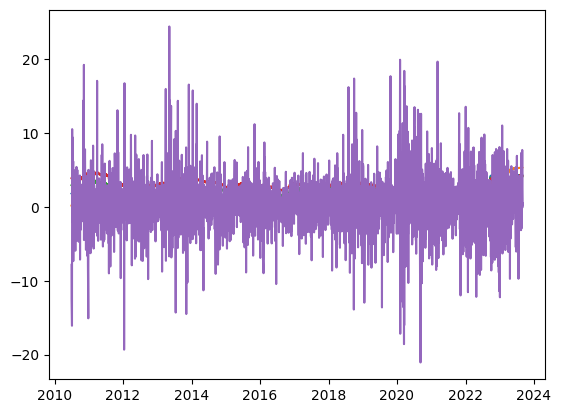

In [54]:
plt.plot(df_daily.index, df_daily[["5Y", "13W", "10Y", "30Y", "percent"]])

In [55]:
df_daily.corr()

,5Y,13W,10Y,30Y,Price,percent
5Y,1.000000,0.845236,0.873464,0.558355,0.252399,-0.043908
13W,0.845236,1.000000,0.602057,0.270711,0.315393,-0.014582
10Y,0.873464,0.602057,1.000000,0.886528,0.006911,-0.044041
30Y,0.558355,0.270711,0.886528,1.000000,-0.246094,-0.030555
Price,0.252399,0.315393,0.006911,-0.246094,1.000000,0.008859
percent,-0.043908,-0.014582,-0.044041,-0.030555,0.008859,1.000000


In [58]:
# Pearson's correlation

cols = df_daily.columns[df_daily.columns != ("Price", "percent")]

for col in cols:
    corr = stats.pearsonr(df_daily["percent"], df_daily[col])
    print("-", col, ":", corr)
    print("")

- 5Y : PearsonRResult(statistic=-0.04390762589217285, pvalue=0.011499310052681361)

- 13W : PearsonRResult(statistic=-0.014581605071994462, pvalue=0.4015260562047477)

- 10Y : PearsonRResult(statistic=-0.04404058951037111, pvalue=0.011250895040867818)

- 30Y : PearsonRResult(statistic=-0.030555426903865084, pvalue=0.07871163614858359)

- Price : PearsonRResult(statistic=0.008859090890448179, pvalue=0.6102910587595763)

- percent : PearsonRResult(statistic=1.0, pvalue=0.0)



5Y, 10Y slightly negative correlation

### Monthly data

In [62]:
# add price change rate

df_monthly["percent"] = df_monthly["Price"].pct_change() * 100
df_monthly.dropna(inplace=True)
df_monthly.head()

,FEDFUNDS,5Y,13W,10Y,30Y,Price,percent
2010-10-01 00:00:00+00:00,0.19,1.271,0.150,2.526,3.721,1.373333,0.733496
2010-11-01 00:00:00+00:00,0.19,1.163,0.105,2.628,4.017,1.427333,3.932041
2010-12-01 00:00:00+00:00,0.18,1.622,0.155,2.964,4.237,2.290000,60.439082
2011-02-01 00:00:00+00:00,0.16,2.021,0.150,3.443,4.613,1.594000,-30.393013
2011-03-01 00:00:00+00:00,0.14,2.118,0.130,3.414,4.490,1.596000,0.125469


In [64]:
df_monthly.corr()

,FEDFUNDS,5Y,13W,10Y,30Y,Price,percent
FEDFUNDS,1.000000,0.830586,0.997616,0.592111,0.268987,0.210784,-0.195934
5Y,0.830586,1.000000,0.838478,0.870380,0.550926,0.181187,-0.271108
13W,0.997616,0.838478,1.000000,0.595674,0.266049,0.236217,-0.191609
10Y,0.592111,0.870380,0.595674,1.000000,0.885253,-0.074675,-0.260707
30Y,0.268987,0.550926,0.266049,0.885253,1.000000,-0.328438,-0.192604
Price,0.210784,0.181187,0.236217,-0.074675,-0.328438,1.000000,0.034198
percent,-0.195934,-0.271108,-0.191609,-0.260707,-0.192604,0.034198,1.000000


In [65]:
# Peason's correlation

cols = df_daily.columns[df_daily.columns != ("Price", "percent")]

for col in cols:
    corr = stats.pearsonr(df_daily["percent"], df_daily[col])
    print("-", col, ":", corr)
    print("")

- 5Y : PearsonRResult(statistic=-0.04390762589217285, pvalue=0.011499310052681361)

- 13W : PearsonRResult(statistic=-0.014581605071994462, pvalue=0.4015260562047477)

- 10Y : PearsonRResult(statistic=-0.04404058951037111, pvalue=0.011250895040867818)

- 30Y : PearsonRResult(statistic=-0.030555426903865084, pvalue=0.07871163614858359)

- Price : PearsonRResult(statistic=0.008859090890448179, pvalue=0.6102910587595763)

- percent : PearsonRResult(statistic=1.0, pvalue=0.0)



### Conclusion

5Y, 10Y slightly negative correlation - very similar to daily data

## Rolling data analysis